In [94]:
# import a utility function for loading Roboflow models
from inference import get_model, InferencePipeline
# import supervision to visualize our results
import supervision as sv
# import cv2 to helo load our image
import cv2
import numpy as np

import pandas as pd
import imageio

from inference.core.interfaces.camera.entities import VideoFrame

ball_bboxes = []
ball_bboxes_large_crop = []

rim_bboxes = []
person_bboxes = []


# custom prediction handler that adds the ball's bounding box data to the dataframe for each video frame
def handle_prediction_shot(p: dict, video_frame: VideoFrame):
    seen_ball = False
    seen_rim = False
        
    for obj in p['predictions']:
        if obj['class'] == "ball" and not seen_ball:
            seen_ball = True
            ball_bboxes.append( np.array([obj['x'] - obj['width'] // 2, obj['y'] - obj['height'] //2, obj['x'] + obj['width'] // 2, obj['y'] + obj['height'] // 2 ]) )
        elif obj['class'] == "rim" and not seen_rim:
            seen_rim = True
            rim_bboxes.append( np.array([obj['x'] - obj['width'] // 2, obj['y'] - obj['height'] // 2, obj['x'] + obj['width'] // 2, obj['y'] + obj['height'] // 2 ]) )
    if not seen_ball:
        ball_bboxes.append(np.zeros((4,)) - 1)
    if not seen_rim:
        rim_bboxes.append(np.zeros((4,)) - 1)



# custom prediction handler that adds the ball's bounding box data to the dataframe for each video frame
def handle_prediction_person(p: dict, video_frame: VideoFrame):
    frame_person_bboxes = []
    seen_ball = False

    for obj in p['predictions']:
        if obj['class'] == "ball" and not seen_ball:
            seen_ball = True
            ball_bboxes_large_crop.append( np.array([obj['x'] - obj['width'] // 2, obj['y'] - obj['height'] //2, obj['x'] + obj['width'] // 2, obj['y'] + obj['height'] // 2 ]) )
        if obj['class'] == "person":
            frame_person_bboxes.append(np.array([obj['x'] - obj['width'] // 2, obj['y'] - obj['height'] // 2, obj['x'] + obj['width'] // 2, obj['y'] + obj['height'] // 2 ]) )
    if not seen_ball:
        ball_bboxes_large_crop.append(np.zeros((4,)) - 1)
    person_bboxes.append(frame_person_bboxes)
    
        
api_key = "IRP2OLTd8fdWQqhQLHaV"

uncropped_video_path = "/home/alex/Downloads/input.MOV" ### uncropped version for person

pipeline = InferencePipeline.init(
    model_id="basketball-w2xcw/1",
    video_reference=uncropped_video_path,
    on_prediction=handle_prediction_person,
    api_key=api_key
)

pipeline.start()
pipeline.join()

cropped_video_path = "/home/alex/Downloads/output.mov" ### cropped version for shot

pipeline = InferencePipeline.init(
    model_id="basketball-w2xcw/1",
    video_reference=cropped_video_path,
    on_prediction=handle_prediction_shot,
    api_key=api_key
)

pipeline.start()
pipeline.join()

rim_bboxes = np.stack(rim_bboxes)
ball_bboxes = np.stack(ball_bboxes)
ball_bboxes_large_crop = np.stack(ball_bboxes_large_crop)



In [18]:
adjustment = np.array([frame.shape[1] // 4, frame.shape[0] // 4, frame.shape[1] // 4, frame.shape[0] //4 ])

In [95]:
import cv2
import numpy as np
def crop_image_with_padding(output_image, y1, y2, x1, x2, vertical_added_pixels, horizontal_added_pixels):
    # Get image dimensions
    H, W = output_image.shape[:2]
    
    # Calculate new coordinates with added pixels, ensuring they stay within bounds
    new_y1 = max(0, int(y1) - vertical_added_pixels)
    new_y2 = min(H, int(y2) + vertical_added_pixels)
    new_x1 = max(0, int(x1) - horizontal_added_pixels)
    new_x2 = min(W, int(x2) + horizontal_added_pixels)
    
    # Crop the image using the new coordinates
    cropped_image = output_image[new_y1:new_y2, new_x1:new_x2]
    
    return cropped_image
    
def get_shirt_color(image, bboxes):
    """
    Segments crops from image using bboxes.
    Returns the average pixel intensity of the region corresponding to t-shirt
    """
    # Make a copy of the image to avoid modifying the original
    output_image = image.copy()

    # Loop through the list of bounding boxes and draw each one
    dists = []
    
    for bbox in bboxes:
        x1, y1, x2, y2 = bbox
        cropped_image = crop_image_with_padding(output_image, y1, y2, x1, x2, 50, 50)
        mask = generate_mask( cropped_image, "t-shirt")
        if np.prod(mask.shape) > 0:
            mask = mask[0]
            dists.append( (cropped_image[mask]/255).mean() )
        else:
            dists.append(None)
    return dists



In [ ]:
reader = imageio.get_reader("/home/alex/Downloads/input.MOV")

for i, frame in enumerate(reader): 
    if i < len(shirt_colors):
        continue
    shirt_color = get_shirt_color(frame, person_bboxes[i])
    shirt_colors.append(shirt_color)
        

In [99]:
def distance_between_bboxes(bbox1, bbox2):
    # Extract the coordinates of the corners of bbox1
    x1_min, y1_min, x1_max, y1_max = bbox1
    x2_min, y2_min, x2_max, y2_max = bbox2
    
    # Compute distances in the x and y directions
    dx = max(x1_min - x2_max, x2_min - x1_max, 0)
    dy = max(y1_min - y2_max, y2_min - y1_max, 0)
    
    # If the bounding boxes overlap, dx and/or dy will be negative or zero
    # When they overlap, the distance is zero
    distance = np.sqrt(dx**2 + dy**2)
    
    return distance

In [100]:
final_ball_bboxes = np.copy(ball_bboxes_large_crop)
better_version_mask = ~((ball_bboxes) == -1).all(axis=-1)
final_ball_bboxes[better_version_mask] = ball_bboxes[better_version_mask] + adjustment

In [101]:
ball_bboxes_uncropped = final_ball_bboxes
ball_bboxes_uncropped[ball_bboxes_uncropped == -1] = -1

white_distance_to_ball = []
black_distance_to_ball = []

for shirt_color, person_bbox, ball_bbox in zip(shirt_colors, person_bboxes[:len(shirt_colors)], ball_bboxes_uncropped[:len(shirt_colors)]):
    if (ball_bbox == -1).all():
        white_distance_to_ball.append(-1)
        black_distance_to_ball.append(-1)
    elif len(person_bbox) == 1:
        dist = distance_between_bboxes(person_bbox[0], ball_bbox)
        if shirt_color[0] < 0.5:
            black_distance_to_ball.append(dist)
            white_distance_to_ball.append(-1)
        else:
            white_distance_to_ball.append(dist)
            black_distance_to_ball.append(-1)           
    else:
        ball_dists = [ distance_between_bboxes(person, ball_bbox) for person in person_bbox ]
        if len(ball_dists) > 2:
            sorted_indices = sorted(range(len(ball_dists)), key=lambda i: ball_dists[i], reverse=False)[:2]
            shirt_color = [shirt_color[i] for i in sorted_indices]
            ball_dists = [ball_dists[i] for i in sorted_indices]
        black_index = np.argmin(shirt_color)
        white_index = (black_index + 1) % 2
        
        white_distance_to_ball.append(ball_dists[white_index])
        black_distance_to_ball.append(ball_dists[black_index])

white_distance_to_ball = np.stack(white_distance_to_ball)
black_distance_to_ball = np.stack(black_distance_to_ball)


In [102]:
import mediapy
import cv2
import numpy as np
from IPython.display import display, Video
#frames = np.stack(frames_orig)

def create_video_with_bboxes(video_path, bboxes, ball_bboxes, output_file='output_video.mp4', window_size = 15):
    # Assume frames is a numpy array of shape (num_frames, height, width, channels)
    # and bboxes is a numpy array of shape (num_frames, 4) with each row [x1, y1, x2, y2]
    reader = imageio.get_reader(video_path)
    current_score_index = -1 * np.inf
    
    first_frame = reader.get_data(0)
    height, width = first_frame.shape[:2]

    ball_points = calculate_central_points(ball_bboxes)
    
    # Define the codec and create a VideoWriter object with MP4 format
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 'mp4v' (or 'x264' might also be used)
    out = cv2.VideoWriter(output_file, fourcc, 20.0, (width, height))
    white_points_count = 0
    black_points_count = 0
    
    # Loop through each frame and the corresponding bbox
    for i, frame in enumerate(reader): #frame, bbox in zip(frames, bboxes):
        if i > white_distance_to_ball.shape[0]:
            break
        bbox = bboxes[i]

        metadata = reader.get_meta_data(i)
        timestamp = metadata.get('timestamp', None)  # Attempt to get the timestamp

        calc_ball_trajectory = False
        
        if i > window_size // 2:
            current_points = ball_points[i - window_size // 2 :i + window_size // 2 + 1].astype(np.int64)
            nearby_last = np.sqrt( ( (current_points - current_points[-1,None])**2).sum(-1) ) < 300
            mask = np.all( current_points > 0, axis = -1)  
            mask = np.logical_and(mask, nearby_last)
            current_points = current_points[mask]
            if current_points.shape[0] > 2:
                ball_line_points = line_of_best_fit(current_points).astype(np.int64)
                calc_ball_trajectory = True
                try:
                    cv2.line(frame, ball_line_points[0], ball_line_points[1], (255, 0, 0), 2)
                    for point in current_points:
                        cv2.circle(frame, point, radius=1, color=(0, 255, 0), thickness=21)  # A green point
                except:
                    pass
        
        # Convert frame to RGB (OpenCV uses BGR by default)
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        
        # Draw the bounding box on the frame
        # Bbox coordinates are assumed to be (x1, y1, x2, y2)
        if np.all(bbox > 0):
            rim_bbox = True
            horizontal_line_at_percentile(bbox, 40)
            rim_line_points = horizontal_line_at_percentile(bbox, 40)
            cv2.line(frame, rim_line_points[0], rim_line_points[1], (255, 0, 0), 2)
            cv2.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 255, 0), 2)
        else:
            rim_bbox = False

        if rim_bbox and calc_ball_trajectory:
            intersection, point = find_intersection(ball_line_points[0],ball_line_points[1], rim_line_points[0], rim_line_points[1])
            slope1 = (ball_line_points[0] - ball_line_points[1])
            slope1 = slope1 / ( np.linalg.norm(slope1) + 1e-8)

            slope2 = (np.array(rim_line_points[0]) - np.array(rim_line_points[1]))
            slope2 = slope2 / np.linalg.norm(slope2)
            
            dot_product = np.abs( (slope1 * slope2).sum() )
            ball_line_height = current_points[0, 1]
            rim_height = rim_line_points[0][1]

            rim_check = ball_line_height <= rim_height
            if intersection and i - current_score_index > 40: #and rim_check: ### 100 frames since last point
                cv2.circle(frame, (int(point[0]), int(point[1])), radius=1, color=(255, 0, 0), thickness=21)  #
                print("POINT!", i, point)
                print(ball_line_height, rim_height)
                current_score_index = i
                white_recent_distance = white_distance_to_ball[i-100:i]
                low_ball_mask = ball_points[i-100:i][...,0] > frame.shape[0] // 2
                white_recent_distance = white_recent_distance[np.logical_and( white_recent_distance != -1, low_ball_mask)].mean()
                white_recent_distance = np.inf if white_recent_distance == np.nan else white_recent_distance
                
                black_recent_distance = black_distance_to_ball[i-100:i]
                black_recent_distance = black_recent_distance[np.logical_and( black_recent_distance != -1, low_ball_mask)].mean()
                black_recent_distance = np.inf if black_recent_distance == np.nan else black_recent_distance

                if white_recent_distance < black_recent_distance:
                    print("WHITE")
                    white_points_count += 1
                else:
                    print("BLACK")
                    black_points_count += 1
        points_string = f'white: {white_points_count}' + "   " + f'black: {black_points_count}'
        cv2.putText(frame, points_string, (width - 700, height - 20), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 2, cv2.LINE_AA)
        
        # Write the frame with the bbox into the file
        out.write(frame)
    
    # Release everything when job is finished
    out.release()
    cv2.destroyAllWindows()
    
    # Display the video in the notebook
    #mediapy.show_video(imageio.mimread(output_file), height=800)


# Create and display the video
create_video_with_bboxes(uncropped_video_path, rim_bboxes + adjustment, ball_bboxes_uncropped, window_size=10)


POINT! 429 [     1023.1         554]
522 554
BLACK
POINT! 542 [     1017.5         553]
513 553
BLACK
POINT! 686 [     1014.4         554]
517 554
WHITE
POINT! 1069 [     1014.6         555]
508 555
BLACK


POINT! 1240 [     1019.8         554]
505 554
BLACK
POINT! 1383 [     1013.5         554]
491 554
WHITE
POINT! 1794 [     1032.4         551]
555 551
WHITE
POINT! 2009 [     1016.7         553]
522 553
BLACK
POINT! 2448 [       1017         554]
521 554
BLACK


POINT! 2553 [       1013         554]
556 554
BLACK
POINT! 2708 [       1012         554]
714 554
WHITE
POINT! 2901 [     1020.7         554]
510 554
WHITE
POINT! 3110 [     1021.2         554]
523 554
BLACK
POINT! 3262 [       1015         553]
511 553
WHITE
POINT! 3556 [     1011.6         552]
527 552
WHITE
POINT! 3749 [     1020.4         553]
488 553
WHITE
POINT! 3924 [       1017         554]
561 554
BLACK
POINT! 4087 [     1020.1         554]
497 554
BLACK
POINT! 4289 [     1017.3         554]
519 554
BLACK
POINT! 4467 [     1012.3         553]
503 553
WHITE
POINT! 4845 [     1025.3         553]
494 553
WHITE
POINT! 5124 [     1011.6         553]
492 553
WHITE


In [7]:
ball_line_points = np.array([[777, 604],
       [820, 332]])

rim_line_points = ((879, 550), (1065, 550))

import numpy as np

def find_intersection(p1, q1, p2, q2):
    """
    Find the intersection point of two line segments p1q1 and p2q2, if it exists.
    
    p1, q1: Endpoints of the first line segment (numpy arrays).
    p2, q2: Endpoints of the second line segment (numpy arrays).
    
    Returns:
    (bool, array): A tuple where the first element is True if the segments intersect,
                   and the second element is the intersection point as a numpy array.
    """
    # Convert input points to numpy arrays if they aren't already
    p1, q1, p2, q2 = map(np.array, [p1, q1, p2, q2])

    # Vector from p1 to q1
    d1 = q1 - p1
    # Vector from p2 to q2
    d2 = q2 - p2
    # Perpendicular vector to d2
    d2_perp = np.array([-d2[1], d2[0]])

    # Solve the equation p1 + t * d1 = p2 + s * d2
    # Rearrange to (p1 - p2) = s * d2 - t * d1
    # Project onto d2_perp: (p1 - p2) . d2_perp = s * d2 . d2_perp (because d1 . d2_perp = 0)
    denom = np.dot(d1, d2_perp)
    if denom == 0:
        return (False, None)  # Parallel or collinear

    # Scalar projection of (p2 - p1) onto d2_perp
    num = np.dot(p2 - p1, d2_perp)
    t = num / denom

    # Check if the intersection point is on the segment p1q1
    if t < 0 or t > 1:
        return (False, None)

    # Find intersection point
    intersection_point = p1 + t * d1

    # Check if the intersection point is on the segment p2q2
    if not (min(p2[0], q2[0]) <= intersection_point[0] <= max(p2[0], q2[0]) and
            min(p2[1], q2[1]) <= intersection_point[1] <= max(p2[1], q2[1])):
        return (False, None)

    return (True, intersection_point)

from numpy import array

Intersection: False Point: None


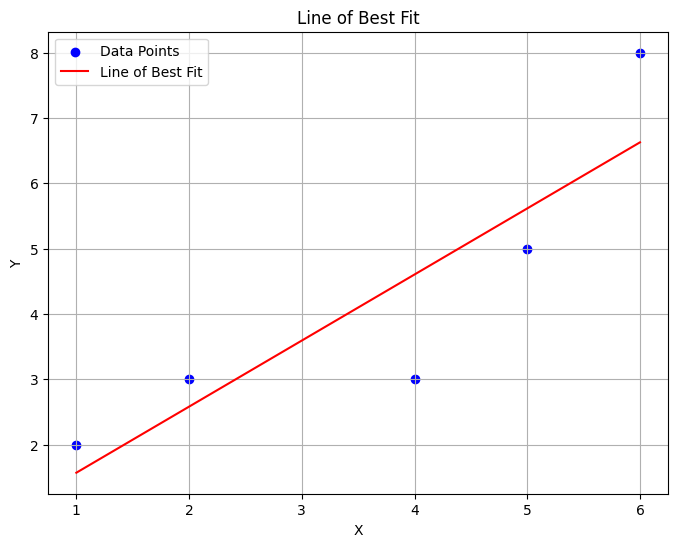

In [8]:
import torch
import matplotlib.pyplot as plt

def line_of_best_fit(points):
    """Calculate the line of best fit for given 2D points."""
    # Ensure points are a torch tensor of the right shape (N, 2)
    #points = np.array(points, dtype=np.float32)
    
    # Extract x and y coordinates
    x = points[:, 0]
    y = points[:, 1]
    
    # Calculate the coefficients for the line y = mx + b
    x_mean = x.mean()
    y_mean = y.mean()
    numerator = np.dot((x - x_mean), (y - y_mean))
    denominator = np.dot((x - x_mean), (x - x_mean))
    m = numerator / denominator
    b = y_mean - m * x_mean
    
    # Determine the x-range for the line endpoints
    x_min, x_max = x.min(), x.max()
    
    # Calculate corresponding y values at x_min and x_max
    y_min = m * x_min + b
    y_max = m * x_max + b
    
    # Create endpoints of the line
    line_endpoints = np.array([[x_min, y_min], [x_max, y_max]])
    
    return line_endpoints

def visualize_line_of_best_fit(points):
    """Visualize the points and the line of best fit."""
    # Calculate the line of best fit endpoints
    line_endpoints = line_of_best_fit(points)
    
    # Convert to numpy for plotting
    points_np = points.numpy()
    line_endpoints_np = line_endpoints
    
    # Plotting the points
    plt.figure(figsize=(8, 6))
    plt.scatter(points_np[:, 0], points_np[:, 1], color='blue', label='Data Points')
    
    # Plotting the line of best fit
    plt.plot(line_endpoints_np[:, 0], line_endpoints_np[:, 1], 'r-', label='Line of Best Fit')
    
    plt.title('Line of Best Fit')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example points
points = torch.tensor([[1, 2], [2, 3], [4, 3], [5, 5], [6, 8]], dtype=torch.float32)

# Visualize the points and the line of best fit
visualize_line_of_best_fit(points)


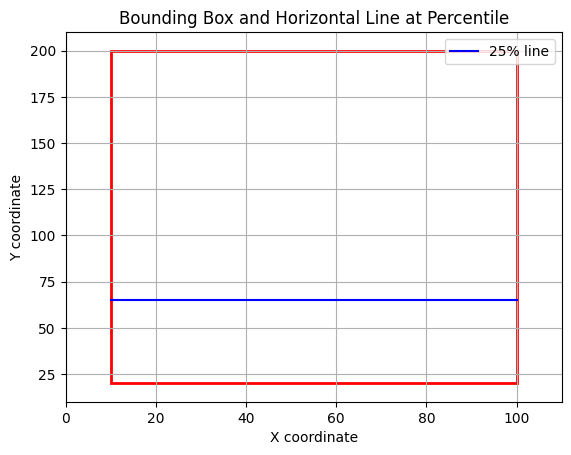

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def calculate_central_points(bboxes):
    """Calculate the central points of bounding boxes."""
    # Convert to a PyTorch tensor if not already one
    
    # Calculate central points (x_center, y_center)
    x_center = (bboxes[:, 0] + bboxes[:, 2]) / 2
    y_center = (bboxes[:, 1] + bboxes[:, 3]) / 2
    
    # Stack the central points into a (N, 2) tensor
    return np.stack((x_center, y_center), axis=1)

def horizontal_line_at_percentile(bbox, percentile):
    """
    Calculate a horizontal line that is a given percentile from the top of the bbox.
    
    Parameters:
    - bbox: Tuple of (x_min, y_min, x_max, y_max)
    - percentile: Float (0-100), the percentile from the top of the bbox
    
    Returns:
    - Tuple containing the coordinates of both endpoints of the horizontal line: 
      ((x_start, y), (x_end, y))
    """
    x_min, y_min, x_max, y_max = bbox
    # Calculate the y-coordinate at the given percentile from the top
    y = y_min + (y_max - y_min) * (percentile / 100.0)

    # Create endpoints of the horizontal line
    line_start = (int(x_min), int(y))
    line_end = (int(x_max), int(y))
    
    return (line_start, line_end)

def visualize_horizontal_line(bbox, percentile):
    """
    Visualize the bounding box and a horizontal line at a specified percentile from the top.
    """
    fig, ax = plt.subplots()
    # Draw the bounding box
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    # Calculate the horizontal line
    line = horizontal_line_at_percentile(bbox, percentile)
    line_start, line_end = line

    # Draw the horizontal line
    plt.plot([line_start[0], line_end[0]], [line_start[1], line_end[1]], 'b-', label=f'{percentile}% line')

    # Set the limits of the plot to slightly beyond the bbox dimensions
    plt.xlim(bbox[0] - 10, bbox[2] + 10)
    plt.ylim(bbox[1] - 10, bbox[3] + 10)

    # Add grid, legend, and labels
    plt.grid(True)
    plt.legend()
    plt.title('Bounding Box and Horizontal Line at Percentile')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.show()

# Example bounding box and percentile
bbox = (10, 20, 100, 200)
percentile = 25

# Visualize the bounding box and the horizontal line at 25% from the top
visualize_horizontal_line(bbox, percentile)


In [10]:
import os
import sys
from PIL import Image

# Add the parent directory to the Python path
parent_dir = os.path.abspath( '..')
sys.path.append(parent_dir)
import torch
from PIL import Image
import ast
from fastsam import FastSAM, FastSAMPrompt
from utils.tools import convert_box_xywh_to_xyxy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import clip
clip_model, preprocess = clip.load('ViT-B/32', device=device) ### WHY DID THEY DO THIS EVERY TIME!!

def call_text_prompt(prompt_process, text):
    if prompt_process.results == None:
        return []
    format_results = prompt_process._format_results(prompt_process.results[0], 0)
    cropped_boxes, cropped_images, not_crop, filter_id, annotations = prompt_process._crop_image(format_results)
    scores = prompt_process.retrieve(clip_model, preprocess, cropped_boxes, text, device=prompt_process.device)
    max_idx = scores.argsort()
    max_idx = max_idx[-1]
    max_idx += sum(np.array(filter_id) <= int(max_idx))
    return np.array([annotations[max_idx]['segmentation']])

class ModelWrapper:
    def __init__(self, model_path, device):
        self.model = FastSAM(model_path)
        self.device = device

    def get_mask(self, input_img, text_prompt=None, point_prompt="[[0,0]]", point_label="[0]", box_prompt="[[0,0,0,0]]", imgsz=1024, iou=0.9, conf=0.4, retina=True, withContours=False, better_quality=False):
        point_prompt = ast.literal_eval(point_prompt)
        box_prompt = convert_box_xywh_to_xyxy(ast.literal_eval(box_prompt))
        point_label = ast.literal_eval(point_label)
        
        everything_results = self.model(
            input_img,
            device=self.device,
            retina_masks=retina,
            imgsz=imgsz,
            conf=conf,
            iou=iou    
        )
        
        bboxes = None
        points = None
        point_label = None
        prompt_process = FastSAMPrompt(input_img, everything_results, device=self.device)
        ann = call_text_prompt(prompt_process, text=text_prompt)
        
        return ann

# Initialize the model once
model_path = '../weights/FastSAM.pt'
model_wrapper = ModelWrapper(model_path, device)

def generate_mask(img_path, text_prompt):
    return model_wrapper.get_mask(img_path, text_prompt)

img = imageio.imread('../roboflow/black_shirt.png')

# Example usage
mask = generate_mask(img, 'shirt')



0: 1024x256 13 objects, 91.2ms
Speed: 4.7ms preprocess, 91.2ms inference, 257.9ms postprocess per image at shape (1, 3, 1024, 1024)
